In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as k
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time

In [134]:
# Load MNIST dataset
MNIST = k.datasets.fashion_mnist.load_data()
#MNIST = k.datasets.mnist.load_data()
# Seperate dataset
training = MNIST[0]
X_train = training[0]
y_train = pd.Series(training[1], name="training targets")
testing = MNIST[1]
X_test = testing[0]
y_test = pd.Series(testing[1], name="testing targets")
# Keep only 1s and 0s for binary classification problem
y_train = y_train[(y_train == 0) | (y_train == 1)]
X_train = X_train[y_train.index]
y_test = y_test[(y_test == 0) | (y_test == 1)]
X_test = X_test[y_test.index]

# y_train[y_train==5] = 1
# y_test[y_test==5] = 1
# X_train[X_train==5] = 1
# X_test[X_test==5] = 1

print(y_train)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print()
print(y_train[y_train == 0].shape, y_train[y_train == 1].shape)
print(y_test[y_test == 0].shape, y_test[y_test == 1].shape)

1        0
2        0
4        0
10       0
16       1
        ..
59985    0
59989    1
59991    1
59996    1
59998    0
Name: training targets, Length: 12000, dtype: uint8
(12000, 28, 28) (2000, 28, 28)
(12000,) (2000,)

(6000,) (6000,)
(1000,) (1000,)


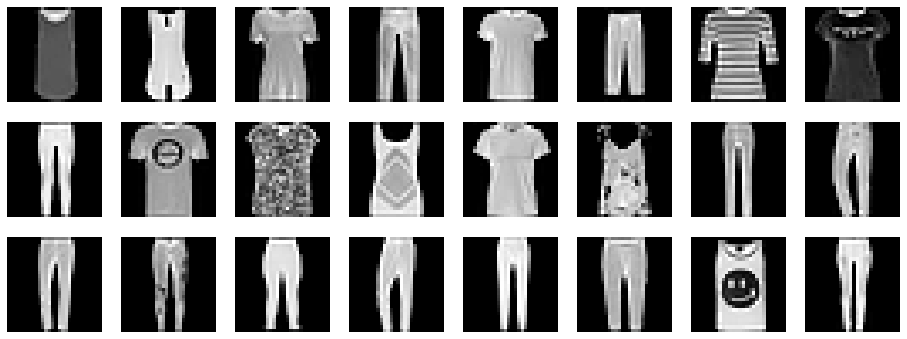

In [135]:
# Visualize training data
plt.figure(figsize=(16,6))
for i in range(24):
    fig = plt.subplot(3, 8, i+1)
    fig.set_axis_off()
    plt.imshow(X_train[i+1], cmap='gray')

# Keras Model

In [136]:
initializer = "random_normal" # random_normal or glorot_uniform
keras_model = k.Sequential([ 
    k.layers.InputLayer(input_shape=(28,28,1)),
    k.layers.Conv2D(filters=32, kernel_size=3, kernel_initializer=initializer),
    k.layers.MaxPooling2D((3,3)),
    #k.layers.Conv2D(filters=32, kernel_size=3, kernel_initializer=initializer),
    k.layers.Flatten(),
    k.layers.Dense(32, activation="relu", kernel_initializer=initializer),
    k.layers.Dense(1, activation="sigmoid", kernel_initializer=initializer)
])
keras_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                65568     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 65,921
Trainable params: 65,921
Non-trainable params: 0
_________________________________________________________________


In [138]:
# Select only m samples for fast training time during debugging
m = 12000
X = X_train[:m, :, :].reshape((m, 28, 28, 1))
y = y_train[:m].values.reshape(1,m)
# Compile model
keras_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss='binary_crossentropy')
# Train model
history = keras_model.fit(x=X, y=y.flatten(), epochs=10)

Epoch 1/10
375/375 [==============================] - 1s 4ms/step - loss: 0.1952
Epoch 2/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0755
Epoch 3/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0583
Epoch 4/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0508
Epoch 5/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0465
Epoch 6/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0434
Epoch 7/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0411
Epoch 8/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0391
Epoch 9/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0371
Epoch 10/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0360


In [139]:
m = 2000
X = X_test[:m, :, :].reshape((m, 28, 28, 1))
y = y_test[:m].values.reshape(1,m)

predictions = keras_model.predict_classes(X)
accuracy_score(predictions, y.flatten())

0.983

# Custom CNN

In [140]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]
    #print(AL)
    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    logprods = np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T)
    cost = -1/m*np.sum(logprods)
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    #print(cost)
    return cost

In [141]:
class Layer:
    """
    Interface for layers.
    """
    def __init__(self, input_shape: tuple, output_shape: tuple, trainable=True):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.trainable = trainable
        
    def forward(self, A_prev):
        pass
    
    def backward(self, dZ):
        pass
    
    def update_params(self, learning_rate):
        pass
    
    def __str__(self):
        return self.__class__.__name__ + " " + str(self.output_shape)
    
    
class Dense(Layer):
    def __init__(self, neurons: int, input_shape: tuple, activation: str):
        """
        Constructor for Conv2D layer.
        
        Arguments:
        neurons (N) -- number of neurons
        input_shape -- (N_prev, m)
        activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
        """
        output_shape = (neurons, input_shape[1])
        super().__init__(input_shape, output_shape)
        self.neurons = neurons
        self.activation = activation
        self.initialize_params()
        
    def initialize_params(self):
        '''
        Definitions:
        self.W -- Weights, numpy array of shape (N, N_prev)
        self.b -- Biases, numpy array of shape (N, 1)
        '''
        self.W = np.random.randn(self.neurons, self.input_shape[0]) * 0.01
        self.b = np.zeros((self.neurons,1))
        
        
    def forward(self, A_prev):
        """
        Implement the forward propagation for the dense layer with activation function

        Arguments:
        A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)

        Returns:
        A -- the output of the activation function, also called the post-activation value 
        
        Defintions:
        self.cache -- tuple of values (A_prev, activation_cache) stored for computing backward propagation efficiently

        """
        Z = np.dot(self.W, A_prev) + self.b
#         print("BEFORE ACTIVATION", Z)
#         print("="*50)
        if self.activation == "sigmoid":
            A, activation_cache = sigmoid(Z)

        elif self.activation == "relu":
            A, activation_cache = relu(Z)
#         print("AFTER ACTIVATION", A)
#         print("="*50)
        assert (A.shape == (self.W.shape[0], A_prev.shape[1]))
        self.cache = (A_prev, activation_cache)

        return A
    
    def backward(self, dA):
        """
        Implement the backward propagation for the dense layer with activation function

        Arguments:
        dA -- post-activation gradient for current layer l 
       
        Returns:
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        
        Definitions:
        self.dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        self.db -- Gradient of the cost with respect to b (current layer l), same shape as b
        """
        A_prev, activation_cache = self.cache
        m = A_prev.shape[1]

        if self.activation == "relu":
            dZ = relu_backward(dA, activation_cache)
        elif self.activation == "sigmoid":
            dZ = sigmoid_backward(dA, activation_cache)
            
        self.dW = 1/m*np.dot(dZ, A_prev.T)
        self.db = 1/m*np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(self.W.T, dZ)

        return dA_prev
    
    def update_params(self, learning_rate):
        self.W = self.W-learning_rate*self.dW
        self.b = self.b-learning_rate*self.db

        
class Conv2D(Layer):
    def __init__(self, filters: int, filter_size: int, input_shape: tuple, padding="VALID", stride=1):
        """
        Constructor for Conv2D layer.
        
        Arguments:
        filters (C) -- number of filters
        filter_size (f) -- size of filters
        input_shape -- (m, H, W, C)
        """
        output_shape = (input_shape[0], input_shape[1] - filter_size + 1, input_shape[2] - filter_size + 1, filters)
        super().__init__(input_shape, output_shape)
        self.filters = filters
        self.filter_size = filter_size
        self.padding = padding
        self.stride = stride
        self.initialize_params()
    
    def initialize_params(self):
        '''
        Definitions:
        self.W -- Weights, numpy array of shape (f, f, C_prev, n_C)
        self.b -- Biases, numpy array of shape (1, 1, 1, n_C)
        '''
        self.W = np.random.randn(self.filter_size, self.filter_size, self.input_shape[3], self.filters) * 0.001
        self.b = np.zeros((self.filters))
        

    def forward(self, A_prev):
        """
        Implements the forward propagation for a convolution function

        Arguments:
        A_prev -- output activations of the previous layer, numpy array of shape (m, H_prev, W_prev, C_prev)
        
        Returns:
        Z -- conv output
        """
        
        # Perform convolution
        Z = tf.raw_ops.Conv2D(input=A_prev, filter=self.W, strides=[self.stride]*4, padding=self.padding)
        # Add bias
        Z = tf.raw_ops.BiasAdd(value=Z, bias=self.b)
        
        # Save information in "cache" for the backprop
        self.cache = A_prev
        # Return the output
        return Z.numpy()
    
    
    def backward(self, dZ):
        """
        Implement the backward propagation for a convolution function
        
        Arguments:
        dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, H, W, C)
        
        Returns:
        dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
                   numpy array of shape (m, H_prev, W_prev, C_prev)
                   
        Definitions:
        self.dW -- gradient of the cost with respect to the weights of the conv layer (W)
              numpy array of shape (f, f, C_prev, C)
        self.db -- gradient of the cost with respect to the biases of the conv layer (b)
              numpy array of shape (1, 1, 1, C)
        """

        # Retrieve information from "cache"
        A_prev = self.cache
        
        dA_prev = tf.raw_ops.Conv2DBackpropInput(input_sizes = A_prev.shape, filter = self.W, out_backprop = dZ, strides=[self.stride]*4, padding=self.padding).numpy()
        self.dW = tf.raw_ops.Conv2DBackpropFilter(input = A_prev, filter_sizes = self.W.shape, out_backprop = dZ, strides=[self.stride]*4, padding=self.padding).numpy()
        self.db = tf.raw_ops.BiasAddGrad(out_backprop=dZ).numpy()
        return dA_prev
    
       
    def update_params(self, learning_rate):
        self.W = self.W-learning_rate*self.dW
        self.b = self.b-learning_rate*self.db

        
class Maxpool(Layer):
    def __init__(self, input_shape, pool_size=2):
        self.ksize = [1, pool_size, pool_size, 1]
        self.strides = [1, pool_size, pool_size, 1]
        output_shape = (input_shape[0], input_shape[1]//pool_size, input_shape[2]//pool_size, input_shape[3])
        super().__init__(input_shape, output_shape, False)

        
    def forward(self, A_prev):
        Z = tf.raw_ops.MaxPool(input=A_prev, ksize=self.ksize, strides=self.strides, data_format='NHWC', padding="VALID").numpy()
        self.cache = (A_prev, Z)
        return Z
    
    def backward(self, dZ):
        A_prev, Z = self.cache
        dA_prev = tf.raw_ops.MaxPoolGrad(orig_input=A_prev, orig_output=Z, grad=dZ, ksize=self.ksize, strides=self.strides, padding="VALID", data_format='NHWC').numpy()
        return dA_prev
    
        
class ReLU(Layer):
    def __init__(self, input_shape):
        output_shape = input_shape
        super().__init__(input_shape, output_shape, False)
           
    def forward(self, Z):
        """
        Implement the RELU function.
        Arguments:
        Z -- Output of the linear layer, of any shape
        Returns:
        A -- Post-activation parameter, of the same shape as Z
        """

        A = np.maximum(0,Z)
        self.cache = Z 
        return A

    def backward(self, dA):
        """
        Implement the backward propagation for a single RELU unit.
        Arguments:
        dA -- post-activation gradient, of any shape
        Returns:
        dZ -- Gradient of the cost with respect to Z
        """

        Z = self.cache
        dZ = np.array(dA, copy=True) # just converting dz to a correct object.

        # When z <= 0, you should set dz to 0 as well. 
        dZ[Z <= 0] = 0

        return dZ
    

class Flatten(Layer):
    def __init__(self, input_shape):
        m, *shape = input_shape
        output_shape = (np.prod(shape), m)
        super().__init__(input_shape, output_shape, False)
        
    def forward(self, A_prev):
        m, *shape = A_prev.shape
        self.cache = A_prev.shape
        return A_prev.flatten().reshape(m,np.prod(shape)).T
    
    def backward(self, dZ):
        return dZ.T.reshape(self.cache)
    
        
class Model:
    def __init__(self, layers: list):
        self.layers = layers
        self.parameters = dict()
        
    def fit(self, X, Y, epochs, learning_rate, verbose, batch_size=32): 
        #print(Y.shape)
        # Prepare the training dataset with batches
        train_dataset = tf.data.Dataset.from_tensor_slices((X, Y.T))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        
        # Initialize parameters
        history = list()
        for epoch in range(epochs):
            for step, (x_batch, y_batch) in enumerate(train_dataset):
                #print(y_batch.numpy().T.shape)
                y_batch = y_batch.numpy().T
                # FORWARD PROP
                Z = x_batch
                for layer in self.layers:    
                    if layer.__str__().split()[0] == "knn_differentiable":
                        Z = layer.forward(Z, y_batch)
                    else:
                        Z = layer.forward(Z)
                    #print(layer, Z.shape)

                # COST FUNCTION
                
                # Keras cost
#                 loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#                 TL = loss(Y, Z)
#                 print("ALT COST", TL)
                
                # our cost
                cost = compute_cost(Z, y_batch)
                history.append(cost)
                if verbose == 1:
                    print("Step {:.0f} in epoch {:.0f} - Cost: {:.8f}\r".format(step, epoch, cost), end="")

                # BACKWARD PROP
                m = y_batch.shape[1]
                dA = -(1/m)*(np.divide(y_batch, Z) - np.divide(1 - y_batch, 1 - Z)) # derivative of cost with respect to Z

                for layer in reversed(self.layers):
                    dA = layer.backward(dA)

                # UPDATE PARAMS
                for layer in self.layers:
                    layer.update_params(learning_rate)
            print("\n\n", "="*75, "\n")

        return history
    
    def predict(self, X, Y):
        Z = X
        for layer in self.layers:
            if layer.__str__().split()[0] == "knn_differentiable":
                Z = layer.forward(Z, Y)
            else:
                Z = layer.forward(Z)
        return Z
    
    def summary(self):
        print("-"*25)
        for layer in layers:
            print(layer)
            print("-"*25)
            
    def _cost(self, X, Y):
        epsilon=1e-7
        Z = X
        for prop_layer in self.layers:
            if prop_layer.__str__().split()[0] == "knn_differentiable":
               #J1 = prop_layer.forward(Z+ epsilon, Y) 
               #J2 = prop_layer.forward(Z- epsilon, Y) 
                
                #print("TESTING: ",(J1-J2)/(2*epsilon))
                
                Z = prop_layer.forward(Z, Y)
            else:
                Z = prop_layer.forward(Z)
            #print(prop_layer, Z)
        # COMPUTE COST
        return compute_cost(Z, Y)
    
    def gradcheck(self, X, Y, epsilon=1e-7, numlayers=None):
        self.approx_grads = []
        self.true_grads = []
        print("Starting loops...")
        j=1
        for layer in self.layers[:numlayers]:
            print(j, len(self.layers))
            j += 1
            if not layer.trainable:
                continue
                
            for i in range(layer.W.size):
                i = np.unravel_index(i, layer.W.shape)
                Wi = layer.W[i]
                layer.W[i] = Wi + epsilon
                J1 = self._cost(X, Y)
                layer.W[i] = Wi - epsilon
                J2 = self._cost(X, Y)
                layer.W[i] = Wi
                #print(J1)
                self.approx_grads.append((J1-J2)/(2*epsilon))
            print("Done W's")  
            for i in range(layer.b.size):
                i = np.unravel_index(i, layer.b.shape)
                bi = layer.b[i]
                layer.b[i] = bi + epsilon
                J1 = self._cost(X, Y)
                layer.b[i] = bi - epsilon
                J2 = self._cost(X, Y)
                layer.b[i] = bi
                #print((J1-J2))
                self.approx_grads.append((J1-J2)/(2*epsilon))
            print("Done B's")
        
        # FORWARD PROP
        Z = X
        for prop_layer in self.layers:
            #print(prop_layer)
            if prop_layer.__str__().split()[0] == "knn_differentiable":
                Z = prop_layer.forward(Z, Y)
            else:
                Z = prop_layer.forward(Z)
                
        # BACKWARD PROP
        m = Y.shape[1]
        dA = -(1/m)*(np.divide(Y, Z) - np.divide(1 - Y, 1 - Z)) # derivative of cost with respect to AL

        for layer in reversed(self.layers):
            dA = layer.backward(dA)
        
        for layer in self.layers[:numlayers]:
            if not layer.trainable:
                continue
            self.true_grads = np.concatenate((self.true_grads, layer.dW.flatten(), layer.db.flatten()))
        return np.sqrt(np.sum(np.square(self.true_grads-self.approx_grads)))/(np.sqrt(np.sum(np.square(self.true_grads)))+np.sqrt(np.sum(np.square(self.approx_grads))))

    
class knn_differentiable(Layer):
    
    def __init__(self, input_shape, num_classes):
        super().__init__(input_shape, num_classes, False)
        
    
    def forward(self, batch_features, batch_labels):
        self.batch_features = np.transpose(batch_features).astype('float')
#         print("BATCH_FEATURES\n", self.batch_features)
#         print()
        self.batch_labels = batch_labels.astype('float')
        
        self.distances = self.calc_distance_mtx(self.batch_features, self.batch_features) / 1000
        #self.distances = np.divide(1, self.distances, where=self.distances!=0)
#         print("DISTANCES\n",self.distances)
#         print()
        
        self.class_0 = np.array(self.batch_labels[:] == 0).astype('float')
        self.class_1 = np.array(self.batch_labels[:] == 1).astype('float')
        self.num_0 = np.count_nonzero(self.batch_labels == 0)
        self.num_1 = np.count_nonzero(self.batch_labels == 1)
#         print("SIZES", self.num_0, self.num_1)
#         print()

        self.aggregate = np.stack([np.sum(np.multiply(self.distances, self.class_0), 1) / self.num_0, np.sum(np.multiply(self.distances, self.class_1), 1) / self.num_1], axis=1)
#         print("AGGREGATE\n", self.aggregate)
#         print()
        
        exp = np.exp(-self.aggregate)
#         print("EXP OF AGGREGATE\n",exp)
#         print(exp[:,0].shape)
#         print()
        
        self.softmax = np.divide(exp[:,1], np.sum(exp, 1))
#         print("SOFTMAX\n",self.softmax[:50])
#         print("="*20)
#         print()
        
        return np.reshape(self.softmax, (1,self.distances.shape[0]))
    
    def backward(self, dA):
        # Overall what we need here:
        # d(TL)/d(X = features) = d(TL)/D(L) * d(L)/d(S) * 
        #     [(d(S)/d(A_0) * d(A_0)/d(D_0) * d(D_0)/d(X)) + (d(S)/d(A_1) * d(A_1)/d(D_1) * d(D_1)/d(X))]
        #
        # Shapes:
        # d(TL)/d(L)  -  (N x 1)           N = number of samples (images)
        # d(L)/d(S)   -  (N x 1)
        # d(S)/d(Ai)  -  (N x 1)
        # d(Ai)/d(Di) -  (N x N)
        # d(Di)/d(X)  -  (N x f)           f = number of features (output by cnn part)
        # final output:  (N x f)
        
        
        # d(TL)/d(L) = -1/m * sum(d(L)/d(S))  <-- Maybe don't need this at all, done before calling backward
        
        
        # d(L)/d(S) = (Y/S) - (1-Y)/(1-S)    <-- Y = true labels, S = softmax labels from column 0 (softmax on class 0)
        dL_dS = dA.T   # <-- Really dTL_dS
        
#         print("dL_dS", dL_dS.shape, dL_dS[:25])
#         print()
        
        
        # d(S)/d(A) = - (e^-A0 * e^-A1) / (e^-2A0 + e^-A0-A1 + e^-2A1)
        # This calc is for A_0 and A_1, A_1 is positive version of this
        #np.square(np.add(np.exp(-self.aggregate[:,0]), np.exp(-self.aggregate[:,1])))
        dS_dA0 = -np.divide(np.multiply(np.exp(-self.aggregate[:,0]), np.exp(-self.aggregate[:,1])), 
                            np.square(np.add(np.exp(-self.aggregate[:,0]), np.exp(-self.aggregate[:,1])))).reshape(self.distances.shape[0],1)
        
        # np.add(np.add(np.exp(-2*self.aggregate[:,0]), np.exp(-2*self.aggregate[:,1])), 
        #                           np.exp(np.multiply(self.aggregate[:,0], self.aggregate[:,1])))
        
        
        dS_dA1 = -dS_dA0
#         print("dS_dA0", dS_dA0.shape, dS_dA0[:25]) (1000,) (1000,1)
#         print()
        
        
        # d(A)/d(D) = 1/len(class) * sum(d(D)/d(X))   <-- Same calc for A_0 and A_1, len(class) = how many of this class there are either num_0 or num_1
        # possibly don't need this part either since its calculated within loops???
        
        
        # d(D)/d(X) = 2(x_i - x_j)   <-- x_i and x_j are the two feature vectors used in the distance
        
        dA0_dX = np.ones(self.batch_features.shape)
        dA1_dX = np.ones(self.batch_features.shape)
        # iterate over rows in distance matrix
        for i in range(self.distances.shape[0]):
            dD0_dX = np.zeros(self.batch_features.shape[1])
            dD1_dX = np.zeros(self.batch_features.shape[1])
            # iterate over the columns in distance matrix
            for j in range(self.distances.shape[1]):
                # only calculate derivatives for indices of class 0
                if self.class_0[:,j] == 0:
                    # first calc derivative of distance formula, then them all together
                    deriv = -2*(self.batch_features[i,:] - self.batch_features[j,:])
                    dD0_dX = np.add(dD0_dX, deriv)
                if self.class_0[:,j] == 1:
                    deriv = -2*(self.batch_features[i,:] - self.batch_features[j,:])
                    dD1_dX = np.add(dD1_dX, deriv)
            # replace the corresponding derivatives for each row (sample)
            dA0_dX[i,:] = dD0_dX
            dA1_dX[i,:] = dD1_dX
            

        
        # Same as loop above but on indices of class 1
#         dA1_dX = np.ones(self.batch_features.shape)
#         for i in range(self.distances.shape[0]):
#             dD1_dX = np.zeros(self.batch_features.shape[1])
#             for j in range(self.distances.shape[1]):
#                 if self.class_0[:,j] == 1:
#                     deriv = -2*(self.batch_features[i,:] - self.batch_features[j,:])
#                     dD1_dX = np.add(dD_dX, deriv)
#             dA1_dX[i,:] = dD_dX
        

        # divide by the number of samples in each class since these were averaged in forward
        dA0_dX = dA0_dX * (1/self.num_0) *(1/1000)
        dA1_dX = dA1_dX * (1/self.num_1) *(1/1000)
#         print("dA0_dX", dA0_dX.shape, dA0_dX)
#         print()
#         print("dA1_dX", dA0_dX.shape, dA1_dX)
#         print()

        # add together the terms in brackets from the full formula
        dS_dX = np.add(np.multiply(dS_dA0, dA0_dX), np.multiply(dS_dA1, dA1_dX))
        # final step of the chain rule
        dL_dX = np.multiply(dL_dS, dS_dX)
#         print("dL_dX", dL_dX.shape, dL_dX)
        
#         print('='*50)
        return dL_dX
        #return np.zeros(self.batch_features.shape)
    
    def calc_distance_mtx(self, A, B):
        """
        Computes squared pairwise distances between each elements of A and each elements of B.
        Args:
        A,    [m,d] matrix
        B,    [n,d] matrix
        Returns:
        D,    [m,n] matrix of pairwise distances
        """
        with tf.compat.v1.variable_scope('pairwise_dist'):
            # squared norms of each row in A and B
            na = tf.reduce_sum(tf.square(A), 1)
            nb = tf.reduce_sum(tf.square(B), 1)

            # na as a row and nb as a co"lumn vectors
            na = tf.reshape(na, [-1, 1])
            nb = tf.reshape(nb, [1, -1])

            # return pairwise euclidead difference matrix
            D = tf.maximum(na - 2*tf.matmul(A, B, False, True) + nb, 0.0)
        return D.numpy()
    
    def calc_cosine_sim(self, A, B):
        from scipy.spatial.distance import pdist
        from scipy.spatial.distance import squareform
        cos_sim = squareform(pdist(A, metric='cosine'))
        return cos_sim

In [211]:
# Select only m samples for fast training time during debugging
#np.random.seed(10)
m = 160

X = X_train[:m, :, :].reshape((m, 28, 28, 1)).astype(float)
y = y_train[:m].values.reshape(1,m)
# Define the layers of the model
layers = [
    Conv2D(32, 3, (None, 28, 28, 1)),
    Maxpool((None, 22, 22, 32), pool_size=3),
    Flatten((None, 1, 1, 32)),
    knn_differentiable((2048, None), 2)
]

# Create and train model
model = Model(layers)
start_time = time.time()
history = model.fit(X, y, epochs=10, learning_rate=0.0015, verbose=1, batch_size=32)
end_time = time.time()
print("Execution Time:", end_time-start_time)

Step 4 in epoch 0 - Cost: 0.49679252


Step 4 in epoch 1 - Cost: 0.45039604


Step 4 in epoch 2 - Cost: 0.46189597


Step 4 in epoch 3 - Cost: 0.39845785


Step 4 in epoch 4 - Cost: 0.36905287


Step 4 in epoch 5 - Cost: 0.32708245


Step 4 in epoch 6 - Cost: 0.19627846


Step 4 in epoch 7 - Cost: 0.35042567


Step 4 in epoch 8 - Cost: 0.35950467


Step 4 in epoch 9 - Cost: 0.43452208


Execution Time: 1.3720808029174805


In [215]:
batch_size = 10
n = 0
m = batch_size
accuracies = []
#print(y_test.values.shape[0]//m)
for i in range(y_test.values.shape[0]//m):
    X = X_test[n:m, :, :].reshape((m-n, 28, 28, 1)).astype(float)
    y = y_test[n:m].values.reshape(1,m-n).astype(float)
    predictions = model.predict(X, y)
    #print(predictions.type)
    #print(y[:,:100])
    print(predictions[:,:100])
    score = accuracy_score(y.flatten(), predictions.flatten().round())
    #print(score)
    accuracies.append(score)
    
    n = m
    m += batch_size
    #print(m,n)

print(accuracies)
print("Average accuracy:", np.average(accuracies))

[[9.99983465e-01 9.99962001e-01 9.99890129e-01 9.99564080e-01
  7.95259059e-05 9.99910000e-01 3.89135064e-02 9.22022435e-01
  9.99995664e-01 9.99738728e-01]]
[[0.05655314 0.99991938 0.99560484 0.16382735 0.99970644 0.9873207
  0.00274944 0.00280653 0.99955826 0.08131807]]
[[9.99995333e-01 3.69113974e-06 5.79847204e-04 1.80639226e-08
  6.70020890e-06 9.99999430e-01 9.99999978e-01 9.99999639e-01
  9.99999990e-01 9.99999759e-01]]
[[1.09060440e-08 9.99043566e-01 1.91733830e-04 9.99999929e-01
  9.99999590e-01 9.99991582e-01 5.05068565e-07 9.99861671e-01
  8.73754404e-01 9.99999951e-01]]
[[9.25621911e-01 3.01707739e-04 9.99269375e-01 6.66484195e-03
  6.90141299e-01 9.94148582e-01 9.99521574e-01 9.97602935e-01
  5.90601053e-02 3.08269594e-01]]
[[9.99989553e-01 9.99982042e-01 9.87337093e-01 8.38147042e-04
  3.43528813e-03 5.14914788e-04 9.99979197e-01 5.17714912e-04
  7.33791755e-07 3.71202202e-01]]
[[9.99988207e-01 1.66894544e-03 7.84444246e-07 5.13597278e-04
  9.99979251e-01 9.33749254e-01 9

[[9.99999978e-01 9.99778281e-01 8.64693528e-02 5.13855214e-04
  3.85319125e-04 1.67251072e-05 1.11072197e-05 9.99998352e-01
  9.99999788e-01 9.99999829e-01]]
[[4.90296610e-01 5.39746135e-04 9.98299382e-01 9.99999487e-01
  9.99993507e-01 3.52709893e-08 1.15247454e-06 4.83426420e-05
  9.99708392e-01 2.59681710e-04]]
[[0.99976713 0.0290819  0.00214536 0.99989322 0.99707528 0.01178428
  0.26464851 0.99995505 0.99786    0.48236318]]
[[0.97833163 0.0141022  0.99977387 0.0186434  0.98994577 0.01542723
  0.95561553 0.01730981 0.99987963 0.99444607]]
[[6.48286562e-04 1.37222361e-05 9.99495030e-01 1.48528676e-01
  3.13880250e-03 3.96625213e-03 2.41232967e-06 9.99948937e-01
  8.14384810e-01 9.99622180e-01]]
[[0.02375426 0.92600214 0.99998095 0.00448609 0.99996141 0.0324249
  0.09011936 0.99996544 0.53922937 0.99998928]]
[[0.16505605 0.99870423 0.99724875 0.99969606 0.9457354  0.00261905
  0.05553425 0.08567346 0.00489406 0.01040536]]
[[9.99989308e-01 4.16662841e-05 9.99883758e-01 9.99894945e-01
 

In [84]:
n = 0
m = 12000
X = X_train[n:m, :, :].reshape((m-n, 28, 28, 1)).astype(float)
y = y_train[n:m].values.reshape(1,m-n).astype(float)
predictions = model.predict(X, y)
#print(predictions.type)
#print(y)
print(predictions)
accuracy_score(y.flatten(), predictions.flatten().round())

[[0.03876595 0.94995055 0.74143983 ... 0.98458477 0.98108052 0.77276491]]


0.8211666666666667

In [241]:
# Select only m samples for fast training time during debugging
#np.random.seed(10)
m = 160
X = X_train[:m, :, :].reshape((m, 28, 28, 1)).astype(float)
y = y_train[:m].values.reshape(1,m)
# Define the layers of the model
layers = [
    Conv2D(32, 3, (None, 28, 28, 1)),
    Maxpool((None, 26, 26, 32), pool_size=3),
    #Conv2D(32, 3, (None, 8, 8, 32)),
    Flatten((None, 8, 8, 32)),
    Dense(32, (2048, None), "relu"),
    Dense(1, (32, None), "sigmoid")
]

#     k.layers.InputLayer(input_shape=(28,28,1)),
#     k.layers.Conv2D(filters=32, kernel_size=3, kernel_initializer=initializer),
#     k.layers.MaxPooling2D((3,3)),
#     k.layers.Flatten(),
#     k.layers.Dense(32, activation="relu", kernel_initializer=initializer),
#     k.layers.Dense(1, activation="sigmoid", kernel_initializer=initializer)

# Create and train model
model = Model(layers)
start_time = time.time()
history = model.fit(X, y, epochs=10, learning_rate=0.0005, verbose=1, batch_size=32)
end_time = time.time()
print("Execution Time:", end_time-start_time)

Step 4 in epoch 0 - Cost: 0.69144499


Step 4 in epoch 1 - Cost: 0.68998352


Step 4 in epoch 2 - Cost: 0.68979612


Step 4 in epoch 3 - Cost: 0.68706695


Step 4 in epoch 4 - Cost: 0.68553497


Step 4 in epoch 5 - Cost: 0.68555434


Step 4 in epoch 6 - Cost: 0.68278765


Step 4 in epoch 7 - Cost: 0.68330999


Step 4 in epoch 8 - Cost: 0.68118162


Step 4 in epoch 9 - Cost: 0.68022033


Execution Time: 0.9606995582580566


In [242]:
batch_size = 2000
n = 0
m = batch_size
accuracies = []
#print(y_test.values.shape[0]//m)
for i in range(y_test.values.shape[0]//m):
    X = X_test[n:m, :, :].reshape((m-n, 28, 28, 1)).astype(float)
    y = y_test[n:m].values.reshape(1,m-n).astype(float)
    predictions = model.predict(X, y)
    #print(predictions.type)
    #print(y[:,:100])
    print(predictions[:,:100])
    score = accuracy_score(y.flatten(), predictions.flatten().round())
    #print(score)
    accuracies.append(score)
    
    n = m
    m += batch_size
    #print(m,n)

print(accuracies)
print("Average accuracy:", np.average(accuracies))

[[0.50767553 0.50726451 0.50433937 0.50417584 0.48556223 0.50759367
  0.49380459 0.49369202 0.50906104 0.50509067 0.49452294 0.50864094
  0.50523759 0.49761844 0.50672254 0.5039751  0.48845146 0.48566275
  0.50731911 0.49454783 0.50268147 0.48468444 0.487439   0.48528741
  0.48575077 0.50497878 0.50905081 0.50570598 0.5098411  0.50679853
  0.48419234 0.49467045 0.4844502  0.50608318 0.5046738  0.50471515
  0.48756663 0.49529079 0.49050552 0.50802571 0.49603712 0.48510718
  0.50704946 0.48686413 0.493576   0.50292618 0.5075331  0.50429494
  0.49183003 0.492618   0.50532188 0.50667749 0.49840631 0.48825203
  0.48990474 0.4860423  0.50388053 0.48621927 0.4863515  0.49181023
  0.50597512 0.48879419 0.48382139 0.48701753 0.50356677 0.49445742
  0.50345005 0.4823904  0.48827532 0.50667005 0.50508459 0.48784151
  0.50303933 0.4911853  0.50763473 0.5060124  0.50410227 0.48911704
  0.48078854 0.5078441  0.4984369  0.4921302  0.48595497 0.50752724
  0.48959561 0.50737889 0.48886398 0.48824205 0.

In [74]:
n = 0
m = 12000
X = X_train[n:m, :, :].reshape((m-n, 28, 28, 1)).astype(float)
y = y_train[n:m].values.reshape(1,m-n).astype(float)
predictions = model.predict(X, y)
#print(predictions.type)
#print(y)
print(predictions)
accuracy_score(y.flatten(), predictions.flatten().round())

[[0.00105568 0.76179028 0.30141488 ... 0.99516018 0.99575939 0.0893973 ]]


0.9659166666666666

In [38]:
# Select only m samples for fast training time during debugging
np.random.seed(10)
m = 25
X = X_train[:m, :, :].reshape((m, 28, 28, 1)).astype(float)
y = y_train[:m].values.reshape(1,m)
# Define the layers of the model
layers = [
    Conv2D(16, 7, (None, 28, 28, 1)),
    #ReLU((None, 22, 22, 16)),
    Maxpool((None, 22, 22, 16)),
    Conv2D(16, 9, (None, 11, 11, 16)),
    #ReLU((None, 8, 8, 32)),
    Maxpool((None, 3, 3, 16)),
    Flatten((None, 1, 1, 16)),
    #Dense(32, (5184, None), "relu"),
    #Dense(1, (32, None), "sigmoid")
    knn_differentiable((64, None), 2)
]

# Create and train model
model = Model(layers)
print(model.gradcheck(X,y, epsilon=1e-7))
pd.DataFrame(np.column_stack((model.true_grads, model.approx_grads)), columns=['true grads', 'approx grads'])

Starting loops...
1 6
Done W's
Done B's
2 6
3 6
Done W's
Done B's
4 6
5 6
6 6
0.7606332886651564


,true grads,approx grads
0,-0.013448,0.052668
1,-0.001167,-0.005450
2,0.008330,-0.024818
3,-0.006284,-0.087154
4,-0.026957,-0.009739
...,...,...
21547,0.008351,-0.000017
21548,0.006610,-0.000027
21549,-0.005742,-0.001199
21550,-0.010412,-0.000043
